In [1]:
# fit binodal curve based on Flory-Huggins Theory
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Tstar_scale = 0.009935
density_scale = 1000 / (50*110) # mg/mL -> mM

def critical(n=1):
    """
    Calculates the critical point for a given polymer length.

    Equation (3) in the paper.

    I don't understand why this works or where these functional
    forms come from?

    Parameters
    -----------------
    n : int
        Polymer length.


    Returns
    ---------------
    np.array of l=2
        Returns an numpy array with 2 elements
        [0] - volume fraction at critical point
        [1] - chi at critical point

    """

    x_c = 0.5 * np.power(1. + 1. / np.sqrt(n), 2)
    phi_c = 1. / (1. + np.sqrt(n))
    return np.array([phi_c, x_c])

def GL_binodal(x, n=1):
    """
    GL = Ginzerberg-Landau

    """

    crit = critical(n)
    x_c = crit[1]
    phi_c = crit[0]

    if not np.array(x).shape:
        if x > x_c:
            t1 = phi_c
            t2 = np.sqrt(3. * (x - x_c) / (2. * np.power(x_c, 2) * np.sqrt(n)))
            return np.array([t1 + t2, t1 - t2, x])
        else:
            raise ValueError('interaction strength too small - no LLPS!')
    else:
        if max(x) < x_c:
            raise ValueError('interaction strength too small - no LLPS!')
        else:
            x = np.array(x)
            x = x[x >= x_c]
            t1 = phi_c
            t2 = np.sqrt(3. * (x - x_c) / (2. * np.power(x_c, 2) * np.sqrt(n)))
            return np.array([t1 + t2, t1 - t2, x])

def binodal(x, n=1, iteration=5, UseImprovedMap=True):

    assert iteration >= 0
    crit = critical(n)
    x_c = crit[1]
    phi_c = crit[0]
    gamma = 1. - 1. / n

    if n == 1:

        guess = GL_binodal(x)

        pp = guess[0]
        xx = guess[2]

        if UseImprovedMap:

            for _ in range(iteration):
                ee = np.exp(- 2 * xx * pp + xx)
                pp = (2. * xx * pp * ee - 1. - ee) / (2. * xx * ee - (1. + ee)**2)

        else:

            for _ in range(iteration):
                ee = np.exp(- 2 * xx * pp + xx)
                pp = 1 / (1 + ee)

        return np.array([pp, 1 - pp, xx])

    if n > 1:

        guess = GL_binodal(x, n=n)

        p1 = guess[0]
        p2 = guess[1]
        xx = guess[2]

        if UseImprovedMap:

            for _ in range(iteration):

                a = np.exp(- 2. * xx * (p1 - p2))
                b = np.exp(- gamma * (p1 - p2) - xx * (np.power(p1, 2) - np.power(p2, 2)))
                c = np.power(a / b, n)

                g1 = (1. - b) / (1. - np.power(a / b, n) * b)
                g2 = (1. - b) / (np.power(b / a, n) - b)

                d1lna = - 2. * xx
                d1lnb = - gamma - xx * 2. * p1
                d2lna = 2. * xx
                d2lnb = gamma + xx * 2. * p2

                j11 = g1**2 * (- d1lnb * b * (1 - c) / (1 - b)**2 + n * (d1lna - d1lnb) * c * b / (1 - b)) - 1
                j21 = g1**2 * (- d2lnb * b * (1 - c) / (1 - b)**2 + n * (d2lna - d2lnb) * c * b / (1 - b))
                j12 = (j11 + 1) * c + g1 * n * c * (d1lna - d1lnb)
                j22 = j21 * c + g1 * n * c * (d2lna - d2lnb) - 1

                detj = j11 * j22 - j12 * j21

                p1_new = np.copy(p1 + (- (g1 - p1) * j22 + (g2 - p2) * j21) / detj)
                p2_new = np.copy(p2 + (- (g2 - p2) * j11 + (g1 - p1) * j12) / detj)

                p1 = p1_new
                p2 = p2_new

        else:

            for _ in range(iteration):

                a = np.exp(- 2. * xx * (p1 - p2))
                b = np.exp(- gamma * (p1 - p2) - xx * (np.power(p1, 2) - np.power(p2, 2)))
                c = np.power(a / b, n)

                g1 = (1. - b) / (1. - np.power(a / b, n) * b)
                g2 = (1. - b) / (np.power(b / a, n) - b)

                p1_new = np.copy((1. - b) / (1. - np.power(a / b, n) * b))
                p2_new = np.copy((1. - b) / (np.power(b / a, n) - b))

                p1 = p1_new
                p2 = p2_new

        return np.array([p1, p2, xx])

def theoretical_binodal(T, Tc, delta_eps=500, rho_scale=1000.0, chi0=0):
    chic = delta_eps / Tc + chi0
    n = ((2*chic)**0.5-1)**(-2)
    chis = delta_eps / T + chi0

    rho_dense, rho_dilute = [], []
    for chi in chis:
        try:
            x = binodal(chi, n=n)
            phi_dense, phi_dilute = x[0], x[1]
            rho_dense.append(phi_dense * rho_scale)
            rho_dilute.append(phi_dilute * rho_scale)
        except ValueError:
            rho_dense.append(np.nan)
            rho_dilute.append(np.nan)
    return np.array(rho_dense), np.array(rho_dilute)

def loss(params, T_sim, rho_dense_exp, rho_dilute_exp, Tc, fit_chi0=True):
    if fit_chi0:
        delta_eps, rho_scale, chi0 = params
    else:
        delta_eps, rho_scale = params
        chi0 = 0.0
    if rho_scale <= 0:
        return np.inf
    rho_dense_th, rho_dilute_th = theoretical_binodal(T_sim, Tc, delta_eps, rho_scale, chi0)
    mask = ~np.isnan(rho_dense_th)
    if not np.any(mask):
        return np.inf
    mse = np.mean((rho_dense_th[mask] - rho_dense_exp[mask])**2 +
                  (rho_dilute_th[mask] - rho_dilute_exp[mask])**2)
    return mse

def fit_FH_binodal(T_sim, rho_dense, rho_dilute, Tc, fit_chi0=False):
    T_sim = np.array(T_sim)
    rho_dense = np.array(rho_dense)
    rho_dilute = np.array(rho_dilute)

    if fit_chi0:
        x0 = [300, 1200.0, 0.0]
    else:
        x0 = [200, 1200.0]
    
    res = minimize(loss, x0, args=(T_sim, rho_dense, rho_dilute, Tc, fit_chi0),
                   method='Nelder-Mead', options={'maxiter': 2000})
    if fit_chi0:
        delta_eps_fit, rho_scale_fit, chi0_fit = res.x
    else:
        delta_eps_fit, rho_scale_fit = res.x
        chi0_fit = 0.0
    T_range = np.linspace(min(T_sim)-100, Tc+1, 1000)
    rho_dense_fit, rho_dilute_fit = theoretical_binodal(T_range, Tc, delta_eps_fit, rho_scale_fit, chi0_fit)
    rho_fit = np.column_stack([rho_dilute_fit, rho_dense_fit[::-1]])
    T_fit = np.column_stack([T_range, T_range[::-1]])
    rhoc = (np.nanmax(rho_dilute_fit) + np.nanmin(rho_dense_fit)) / 2

    return rho_fit, T_fit, rhoc

In [2]:
# unified style for plots
def apply_pub_style(ax, remove_spines=True):
    ax.minorticks_on()
    ax.tick_params(direction='in', which='both', labelsize=11, top=False, right=False)
    if remove_spines:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['right'].set_linewidth(1.0)

/home/swalker/.conda/envs/cg2all/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/tmp/ipykernel_2679360/1136607661.py:117: RuntimeWarning: invalid value encountered in power
  return A * (Tc - T)**beta - delta_rho


321.8569584748744


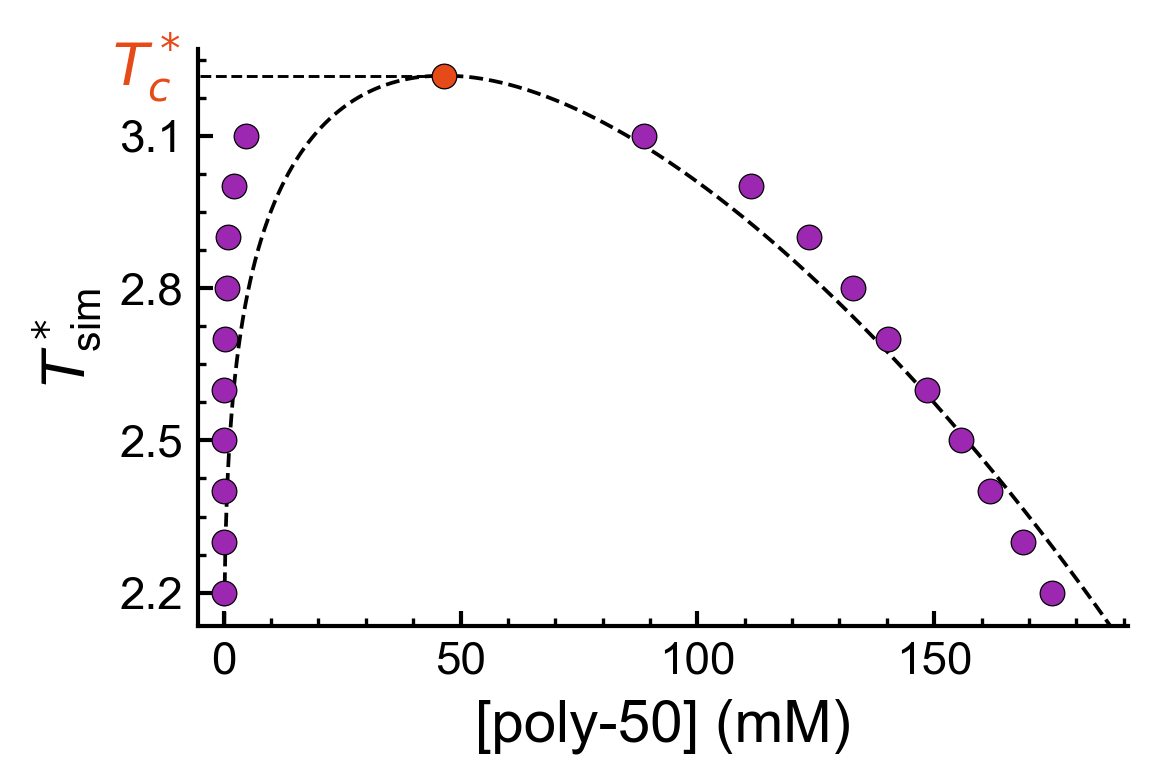

In [ ]:
# Fig.A
import sys, os, numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import leastsq

def apply_pub_style(ax, remove_spines=True):
    ax.minorticks_on()
    ax.tick_params(direction='in', which='both', labelsize=11, top=False, right=False)
    if remove_spines:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['right'].set_linewidth(1.0)

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.0 
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.8

# fig, ax = plt.subplots(1, 1, figsize=[3.2, 3], facecolor='w', dpi=300)
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=300)
apply_pub_style(ax, remove_spines=True)

## Plot density profile
protein = 'poly50'
data_folder = f'data/poly50/hps'
RHO_H, RHO_L, T = [], [], []
for temp in range(220, 360, 10):
    traj_dir = f'traj/{protein}/hps/{temp}/{temp}'
    if not os.path.exists(f'traj/{protein}/hps/{temp}'):
        continue
    u = mda.Universe(f'{traj_dir}.gsd', f'{traj_dir}.dcd')
    nlen = len(u.trajectory)
    natoms = u.atoms.n_atoms
    mass = u.atoms.masses
    name = u.atoms.names
    box = u.dimensions
    lenx, leny, lenz = box[0], box[1], box[2]
    zmax, zmin = lenz / 2, - lenz / 2
    nbins = 500
    nres = 168
    dz = lenz / nbins
    axisz = np.linspace(zmin, zmax, nbins)

    if os.path.exists(f'{data_folder}/{temp}_dp.npy'):
        rhoave = np.load(f'{data_folder}/{temp}_dp.npy')
    else:
        count = 0
        rhosum = np.zeros(nbins)
        for frame in np.arange(300, nlen, 2):
            if frame % 100 == 0:
                print(frame)
            ts = u.trajectory[frame]
            cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
            massz = np.zeros(nbins)
            for i in range(natoms):
                nposz = ts.positions[i][2] - cmassz
                nmass = mass[i]
                idx = int((nposz - zmin) / dz)
                if idx >= 500:
                    idx -= 500
                if idx < 0:
                    idx += 500
                massz[idx] += nmass
            rhoz = massz / (lenx * leny * dz * 6.02214e-1)
            rhosum += rhoz
            count += 1
        rhoave = rhosum / count
        rhoidx = np.where(rhoave > max(rhoave) * 0.2)
        mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
        if mc_idx > 0:
            tmp = rhoave[:mc_idx].copy()
            rhoave[:-mc_idx] = rhoave[mc_idx:]
            rhoave[-mc_idx:] = tmp
        if mc_idx < 0:
            tmp = rhoave[mc_idx:].copy()
            rhoave[-mc_idx:] = rhoave[:mc_idx]
            rhoave[:-mc_idx] = tmp
        
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)
        np.save(f'{data_folder}/{temp}_dp.npy', rhoave)
    
    rho_max = max(rhoave)
    rho_min = min(rhoave)
    rho_hd, rho_ld = 0, 0
    count_hd, count_ld = 0, 0
    for rho in rhoave:
        if rho >= rho_max * 0.95:
            rho_hd += rho
            count_hd += 1
        if rho <= rho_min + 50:
            rho_ld += rho
            count_ld += 1
    rho_hd /= count_hd
    rho_ld /= count_ld

    rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
    rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

    if abs(rho_hd - rho_ld) <= 50:
        continue

    T.append(temp)
    RHO_H.append(rho_hd)
    RHO_L.append(rho_ld)

def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

def err_rhoc(param, T, rho_ave):
    B, C = param
    return rho_ave - (B + C * T)

RHO_H = np.array(RHO_H)
RHO_L = np.array(RHO_L)
T = np.array(T)

delta_rho = RHO_H - RHO_L
rho_ave = (RHO_H + RHO_L) / 2
T_prods = T
param = leastsq(err_Tc, [100, 400], args=(T_prods, delta_rho))
A, T_c = param[0]
param = leastsq(err_rhoc, [0, 0], args=(T_prods, rho_ave))
B, C = param[0]
rho_c = B + C * T_c

print(T_c)

## Plot original T
rho_fit, T_fit, rhoc = fit_FH_binodal(T, RHO_H, RHO_L, T_c, fit_chi0=False)
plt.scatter(RHO_H*density_scale, T*Tstar_scale, s=35, c='#9C27B0', edgecolors='k', linewidths=0.3, zorder=10)
plt.scatter(RHO_L*density_scale, T*Tstar_scale, s=35, c='#9C27B0', edgecolors='k', linewidths=0.3, zorder=10)
plt.scatter(rhoc*density_scale, T_c*Tstar_scale, s=35, c='#E64A19', edgecolors='k', linewidths=0.3, zorder=10)
plt.plot(rho_fit*density_scale, T_fit*Tstar_scale, c='k', ls='--', lw=0.9)

# plt.plot([-100, 730*density_scale], [280*Tstar_scale, 280*Tstar_scale], '--k', linewidth=0.7)
# plt.plot([-100, 490*density_scale], [310*Tstar_scale, 310*Tstar_scale], '--k', linewidth=0.7)
plt.plot([-100, rhoc*density_scale], [T_c*Tstar_scale, T_c*Tstar_scale], '--k', linewidth=0.7)

plt.xlim(-30*density_scale, 1050*density_scale)
plt.ylim(2.12, 3.25)
plt.xlabel('[poly-50] (mM)', fontsize=14)
plt.ylabel(r'$T_\mathregular{sim}^*$', fontsize=14)
plt.yticks([220*Tstar_scale, 250*Tstar_scale, 280*Tstar_scale, 310*Tstar_scale])
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.text(-130*density_scale, 320*Tstar_scale, r'$T_c^*$', fontsize=14, color='#E64A19')
plt.savefig(f"../../figures/phase-diagram/new_plot/density-profile.svg", format="svg", bbox_inches='tight')
plt.show()

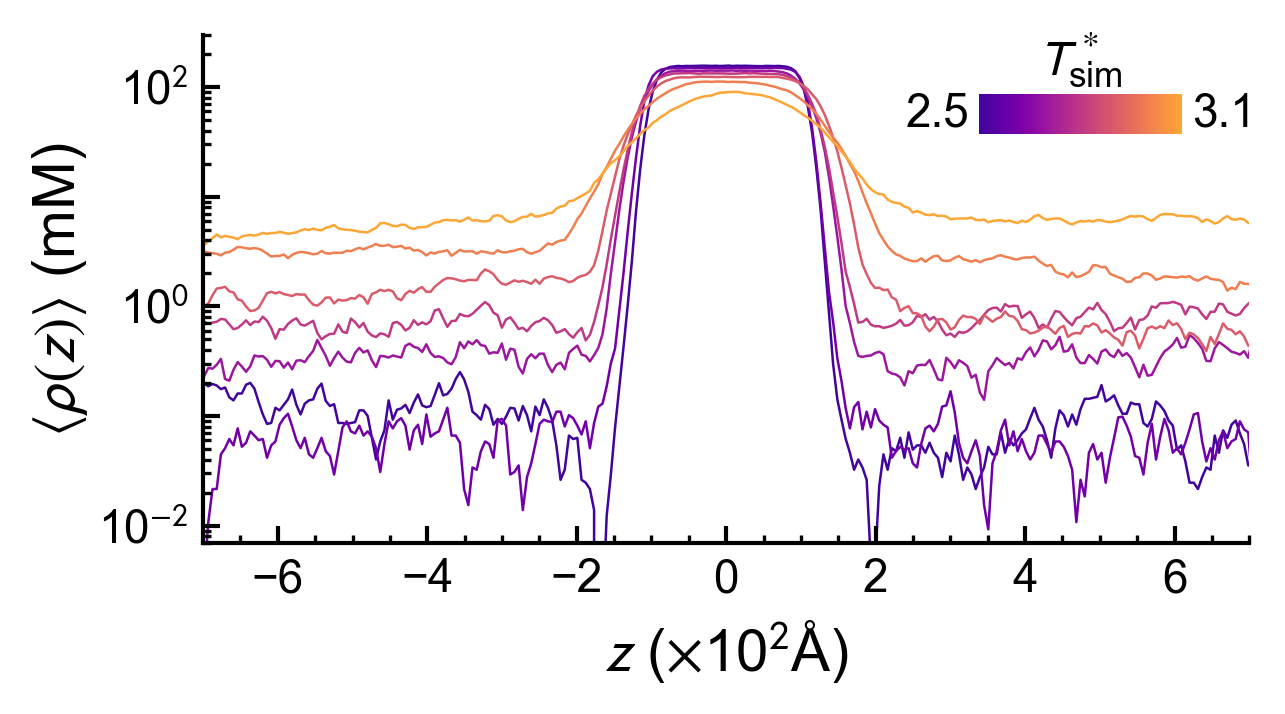

In [270]:
import os
import numpy as np
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib import colors, ticker
from matplotlib.colors import Normalize, LinearSegmentedColormap
from scipy.optimize import curve_fit

def slab_fit(z, rho_l, rho_v, z0, w):
    return rho_v + 0.5 * (rho_l - rho_v) * (np.tanh((z - z0)/w) - np.tanh((z + z0)/w))

def fit_slab_function(rho, axisz):
    
    z = axisz
    rho_max = np.max(rho)
    rho_min = np.min(rho)
    if rho_max == 0 or (rho_max - rho_min) < 0.25 * rho_max:
        return None
    
    p0 = [rho_max, rho_min, max(axisz)*0.1, 1.0]
    try:
        popt, _ = curve_fit(slab_fit, z, rho, p0=p0, maxfev=5000)
        rho_fit = slab_fit(z, *popt)
    except:
        return None
        
    return rho_fit

protein = 'poly50'
folder = 'hps'

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.8
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['mathtext.default'] = 'it'

fig, ax = plt.subplots(1, 1, figsize=[4.5, 2.2], facecolor='w', dpi=300)

tlist = np.arange(250, 320, 10)
data_folder = f'data/{protein}/{folder}'
cmap = cm.plasma
clist = cmap(np.linspace(0.1, 0.8, len(tlist)))
for index, temp in enumerate(tlist):
    traj_folder = f'traj/{protein}/{folder}/{temp}'
    if not os.path.exists(traj_folder):
        continue
    u = mda.Universe(f'{traj_folder}/{temp}.gsd', f'{traj_folder}/{temp}.dcd', pbc=True)
    at = u.select_atoms('all')
    nlen = len(u.trajectory)
    natoms = u.atoms.n_atoms
    mass = u.atoms.masses
    name = u.atoms.names
    box = u.dimensions
    lenx, leny, lenz = box[0], box[1], box[2]
    zmax, zmin = lenz / 2, - lenz / 2
    nbins = 500
    nres = 168
    dz = lenz / nbins
    axisz = np.linspace(zmin, zmax, nbins)

    if os.path.exists(f'{data_folder}/{temp}_dp1.npy'):
        rhoave = np.load(f'{data_folder}/{temp}_dp1.npy')
    else:
        count = 0
        rhosum = np.zeros(nbins)
        for frame in np.arange(300, nlen, 1):
            ts = u.trajectory[frame]
            cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
            massz = np.zeros(nbins)
            for i in range(natoms):
                nposz = ts.positions[i][2] - cmassz
                nmass = mass[i]
                idx = int((nposz - zmin) / dz)
                if idx >= 500:
                    idx -= 500
                if idx < 0:
                    idx += 500
                massz[idx] += nmass
            rhoz = massz / (lenx * leny * dz * 6.02214e-1)
            rhosum += rhoz
            count += 1
        rhoave = rhosum / count
        rhoidx = np.where(rhoave > max(rhoave) * 0.2)
        mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
        if mc_idx > 0:
            tmp = rhoave[:mc_idx].copy()
            rhoave[:-mc_idx] = rhoave[mc_idx:]
            rhoave[-mc_idx:] = tmp
        if mc_idx < 0:
            tmp = rhoave[mc_idx:].copy()
            rhoave[-mc_idx:] = rhoave[:mc_idx]
            rhoave[:-mc_idx] = tmp
        
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)
        np.save(f'{data_folder}/{temp}_dp1.npy', rhoave)
    
    rhoave = rhoave*density_scale
    ax.plot(axisz/10, rhoave, lw=0.6, color=clist[index], zorder=0.5)

    rhofit = fit_slab_function(rhoave, axisz)
    # ax.plot(axisz/10, rhofit, lw=0.4, ls='--', color=clist[index], zorder=0.6)

cbar_ax = fig.add_axes([0.7, 0.73, 0.15, 0.06])
cmap_partial = mpl.colors.ListedColormap(cmap(np.linspace(0.1, 0.8, 256)))
norm_bar = Normalize(vmin=-1, vmax=1)
sm = mpl.cm.ScalarMappable(cmap=cmap_partial, norm=norm_bar)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.outline.set_linewidth(0.)
cbar.set_ticks([])

cbar_ax.text(0.5, 1.5, r'$T^*_\mathregular{sim}$', fontsize=12, transform=cbar_ax.transAxes, ha='center')
cbar_ax.text(-0.05, 0.2, '{:.1f}'.format(min(tlist)*Tstar_scale), fontsize=11, transform=cbar_ax.transAxes, ha='right')
cbar_ax.text(1.05, 0.2, '{:.1f}'.format(max(tlist)*Tstar_scale), fontsize=11, transform=cbar_ax.transAxes, ha='left')

ax.set_xlim(-7, 7)
ax.set_ylim(0.007, 300)
ax.set_xlabel(r'$z$ ($\times$10$^2 \mathregular{\AA}$)', fontsize=14)
ax.set_ylabel(r'$\langle\rho(z)\rangle$ (mM)', fontsize=14, labelpad=2)
ax.set_yscale('log')

major_locator = ticker.LogLocator(base=10.0, numticks=15)
ax.yaxis.set_major_locator(major_locator)
def custom_log_formatter(x, pos):
    log_val = np.log10(x)
    val_int = int(round(log_val))
    if val_int % 2 == 0:
        return r'10$^{{{}}}$'.format(val_int)
    else:
        return ""

ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_log_formatter))
locmin = ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 1.0, numticks=200)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(direction='in', which='both', labelsize=11, top=False, right=False)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

# ax.minorticks_on()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(f"../../figures/phase-diagram/new_plot/density_dist.svg", format="svg", bbox_inches='tight')
plt.show()

/tmp/ipykernel_2679360/2950657651.py:17: RuntimeWarning: invalid value encountered in power
  return A * (Tc - T)**beta - delta_rho
/tmp/ipykernel_2679360/2566504744.py:110: RuntimeWarning: overflow encountered in power
  g2 = (1. - b) / (np.power(b / a, n) - b)


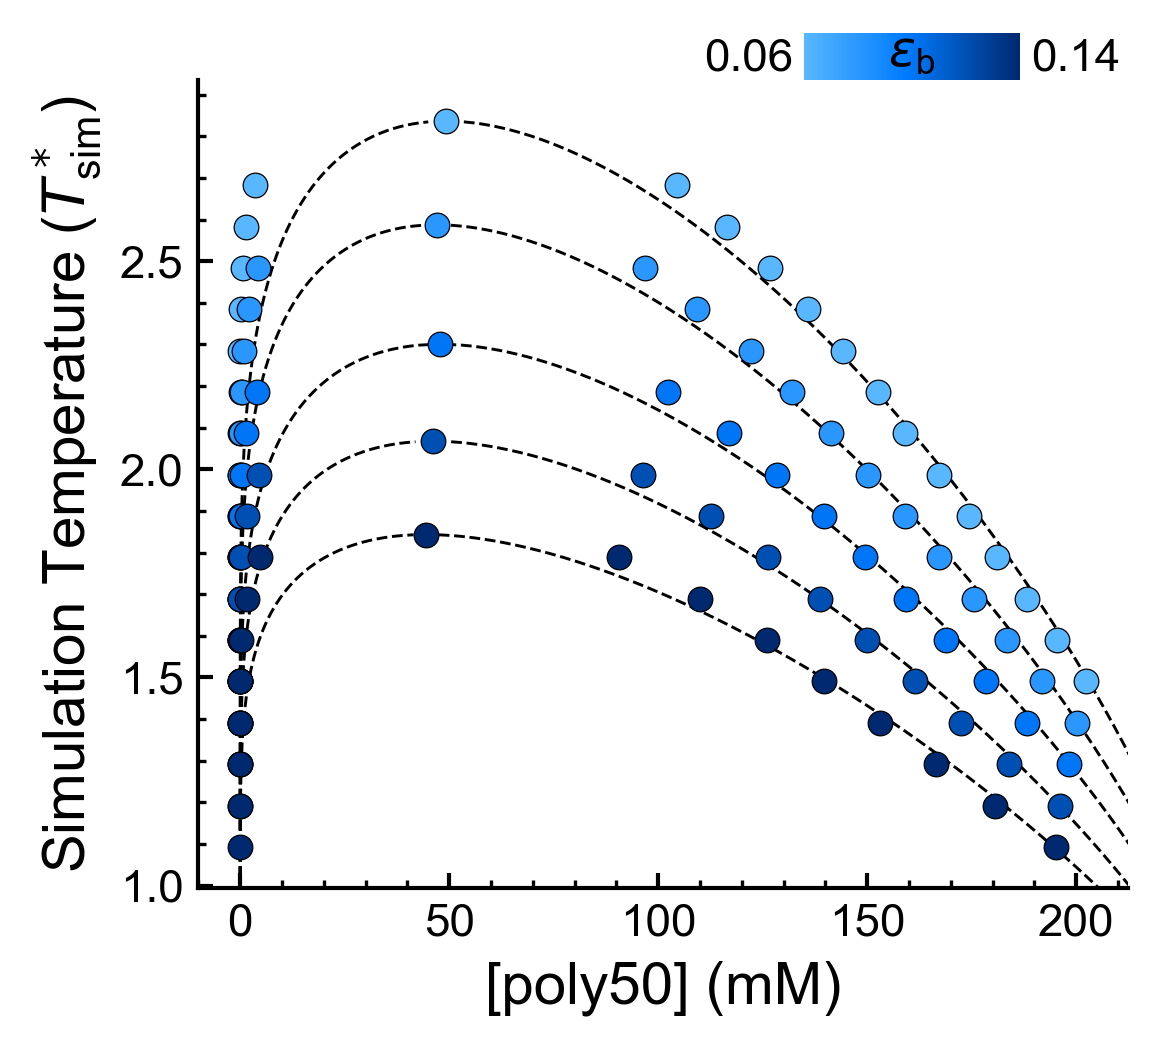

/tmp/ipykernel_2679360/2566504744.py:152: RuntimeWarning: divide by zero encountered in divide
  chis = delta_eps / T + chi0
/tmp/ipykernel_2679360/2566504744.py:106: RuntimeWarning: invalid value encountered in scalar subtract
  b = np.exp(- gamma * (p1 - p2) - xx * (np.power(p1, 2) - np.power(p2, 2)))
/tmp/ipykernel_2679360/2566504744.py:117: RuntimeWarning: invalid value encountered in scalar subtract
  j11 = g1**2 * (- d1lnb * b * (1 - c) / (1 - b)**2 + n * (d1lna - d1lnb) * c * b / (1 - b)) - 1
/tmp/ipykernel_2679360/2566504744.py:119: RuntimeWarning: invalid value encountered in scalar subtract
  j12 = (j11 + 1) * c + g1 * n * c * (d1lna - d1lnb)
/tmp/ipykernel_2679360/2566504744.py:107: RuntimeWarning: invalid value encountered in scalar divide
  c = np.power(a / b, n)
/tmp/ipykernel_2679360/2566504744.py:109: RuntimeWarning: invalid value encountered in scalar divide
  g1 = (1. - b) / (1. - np.power(a / b, n) * b)
/tmp/ipykernel_2679360/2566504744.py:110: RuntimeWarning: invali

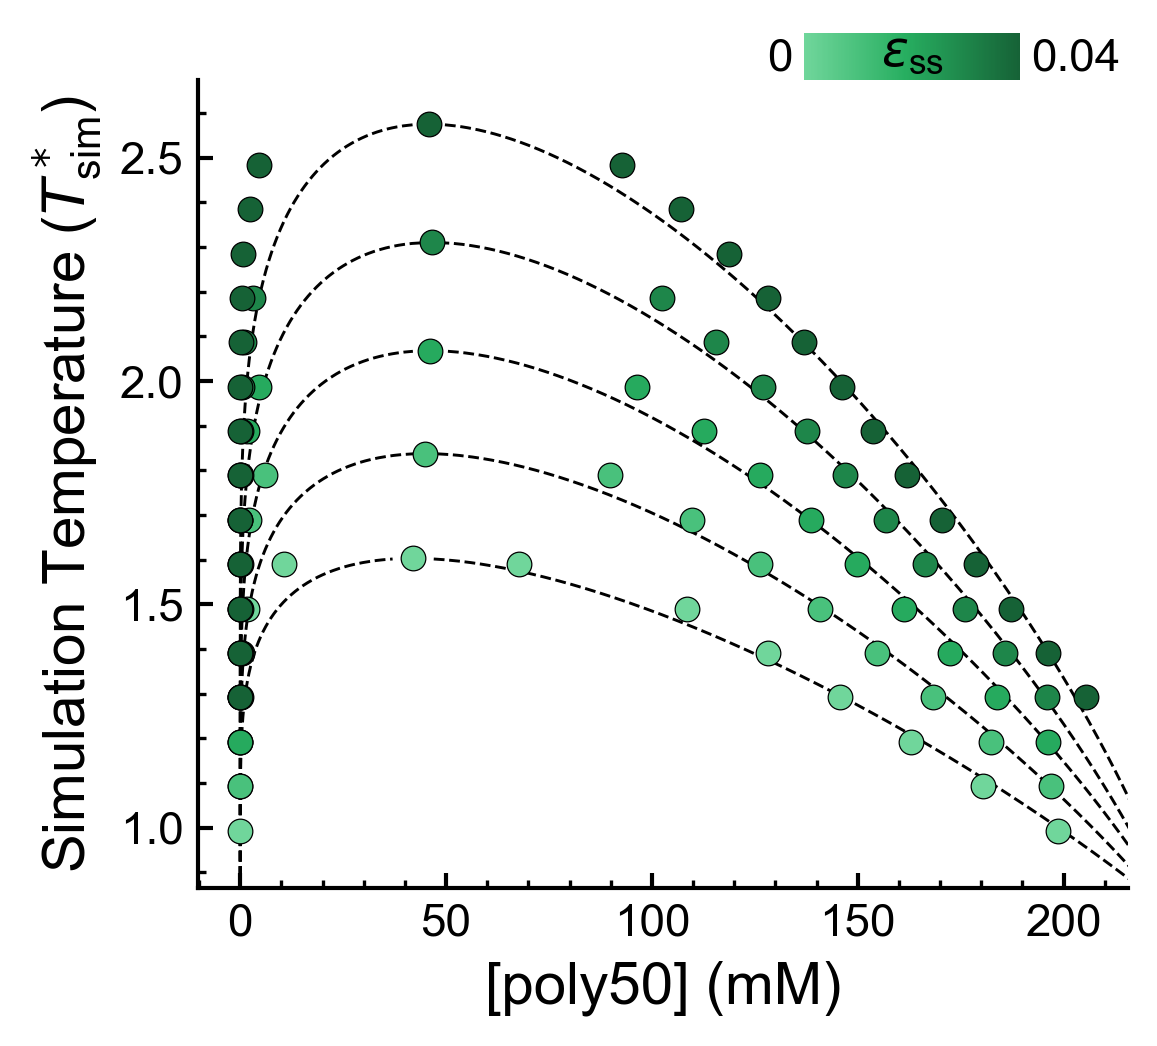

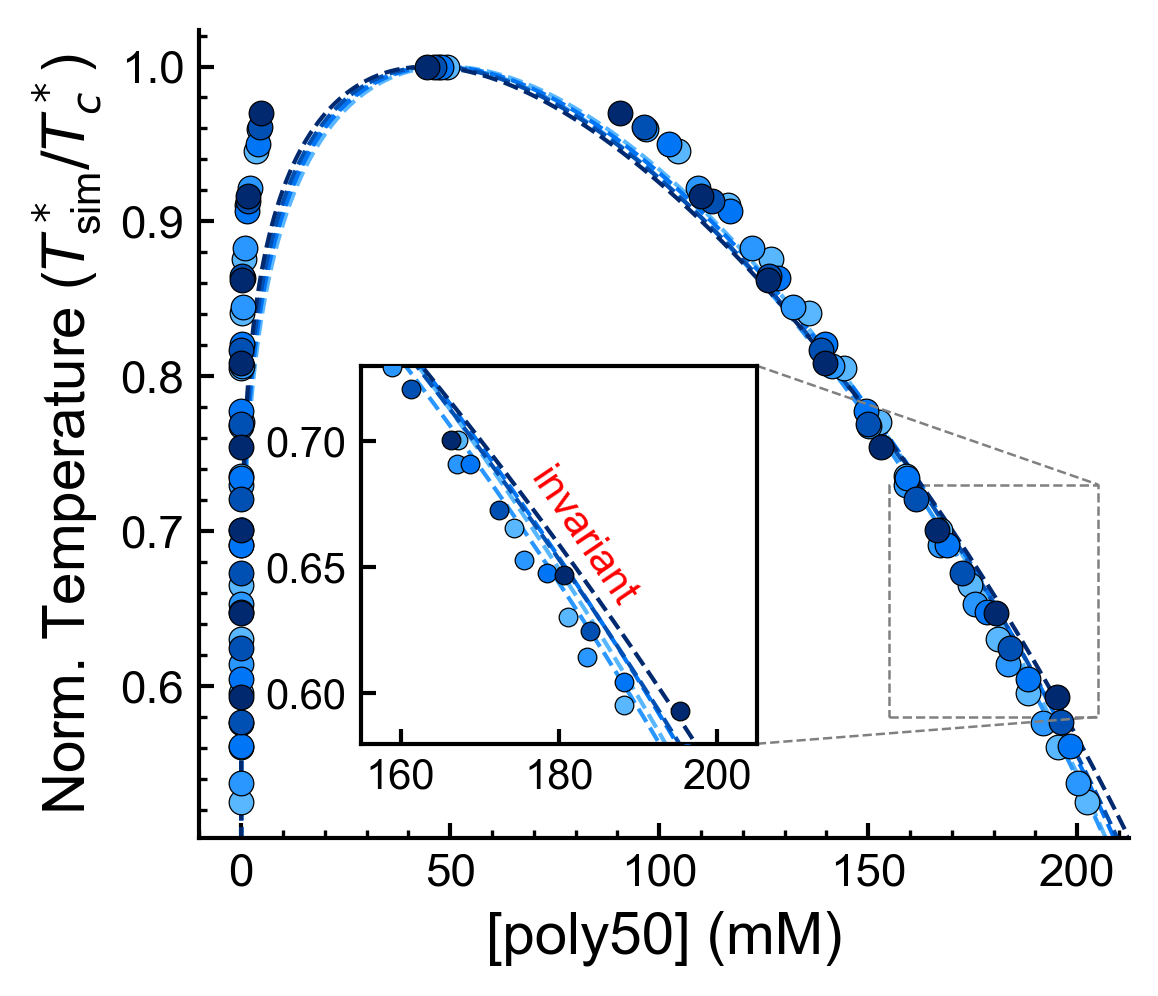

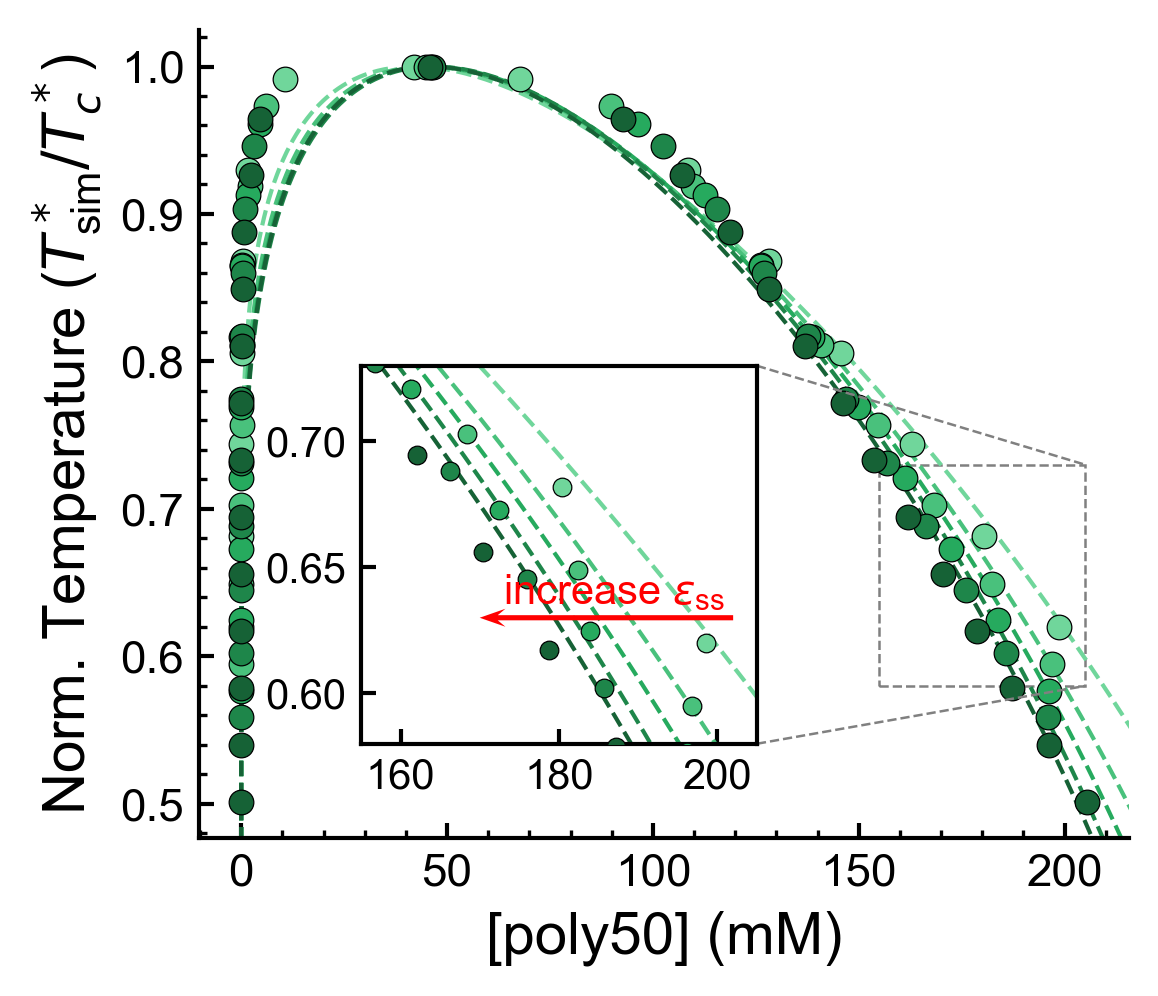

In [ ]:
# Fig.D/E/H/I
import os
import numpy as np
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.optimize import leastsq
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

## Plot coexistence curve
def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

def err_rhoc(param, T, rho_ave):
    B, C = param
    return rho_ave - (B + C * T)

def calculate_phase_diagram(fixed_part):

    protein = 'poly50'
    density_data = {} # concentration of high/low density phase
    if fixed_part == 'eb':
        fix_value = '0.12'
        param_idx, label_idx = 2, 3
    if fixed_part == 'ew':
        fix_value = '0.02'
        param_idx, label_idx = 3, 2

    ## Plot density profile
    folders = os.listdir(f'traj/{protein}')
    for folder in folders:
        param = folder.split('_')
        if len(param) == 1: # removing HPS model or not
            continue
        if len(param) != 1 and param[param_idx] != fix_value:
            continue
        data_folder = f'data/{protein}/{folder}'
        RHO_H, RHO_L, T = [], [], []
        for temp in range(0, 1000, 1):
            traj_folder = f'traj/{protein}/{folder}/{temp}'
            if not os.path.exists(traj_folder):
                continue
            u = mda.Universe(f'{traj_folder}/{temp}.gsd', f'{traj_folder}/{temp}.dcd', pbc=True)
            nlen = len(u.trajectory)
            natoms = u.atoms.n_atoms
            mass = u.atoms.masses
            box = u.dimensions
            lenx, leny, lenz = box[0], box[1], box[2]
            zmax, zmin = lenz / 2, - lenz / 2
            nbins = 500
            dz = lenz / nbins

            if os.path.exists(f'{data_folder}/{temp}_dp.npy'):
                rhoave = np.load(f'{data_folder}/{temp}_dp.npy')
            else:
                count = 0
                rhosum = np.zeros(nbins)
                for frame in np.arange(300, nlen, 2):
                    if frame % 100 == 0:
                        print(frame)
                    ts = u.trajectory[frame]
                    cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
                    massz = np.zeros(nbins)
                    for i in range(natoms):
                        nposz = ts.positions[i][2] - cmassz
                        nmass = mass[i]
                        idx = int((nposz - zmin) / dz)
                        if idx >= 500:
                            idx -= 500
                        if idx < 0:
                            idx += 500
                        massz[idx] += nmass
                    rhoz = massz / (lenx * leny * dz * 6.02214e-1)
                    rhosum += rhoz
                    count += 1
                rhoave = rhosum / count
                rhoidx = np.where(rhoave > max(rhoave) * 0.2)
                mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
                if mc_idx > 0:
                    tmp = rhoave[:mc_idx].copy()
                    rhoave[:-mc_idx] = rhoave[mc_idx:]
                    rhoave[-mc_idx:] = tmp
                if mc_idx < 0:
                    tmp = rhoave[mc_idx:].copy()
                    rhoave[-mc_idx:] = rhoave[:mc_idx]
                    rhoave[:-mc_idx] = tmp
                
                if not os.path.exists(data_folder):
                    os.makedirs(data_folder)
                np.save(f'{data_folder}/{temp}_dp.npy', rhoave)
            
            rho_max = max(rhoave)
            rho_min = min(rhoave)
            rho_hd, rho_ld = 0, 0
            count_hd, count_ld = 0, 0
            for rho in rhoave:
                if rho >= rho_max * 0.95:
                    rho_hd += rho
                    count_hd += 1
                if rho <= rho_min + 50:
                    rho_ld += rho
                    count_ld += 1
            rho_hd /= count_hd
            rho_ld /= count_ld

            rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
            rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

            if abs(rho_hd - rho_ld) <= 50:
                continue

            T.append(temp)
            RHO_H.append(rho_hd)
            RHO_L.append(rho_ld)
        
        density_data[param[label_idx]] = [np.array(T), np.array(RHO_H), np.array(RHO_L)]

    tc_list = {}
    for parameter_set in density_data:
        T = density_data[parameter_set][0]
        RHO_H = density_data[parameter_set][1]
        RHO_L = density_data[parameter_set][2]
        
        delta_rho = RHO_H - RHO_L
        T_prods = T
        param = leastsq(err_Tc, [100, 400], args=(T_prods, delta_rho), full_output=True)
        A, T_c = param[0]
        terr = np.sqrt(np.diag(param[1]))[1]

        tc_list[parameter_set] = T_c
    
    return density_data, tc_list

def apply_pub_style(ax, remove_spines=True):
    ax.minorticks_on()
    ax.tick_params(direction='in', which='both', labelsize=11, top=False, right=False)
    if remove_spines:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['top'].set_linewidth(1.0)
        ax.spines['right'].set_linewidth(1.0)

def plot_T(fixed_part):

    density_data, tc_list = calculate_phase_diagram(fixed_part)
    data_sorted = sorted(density_data.keys(), reverse=False)

    if fixed_part == 'eb':
        label_tag = '\epsilon_{\mathregular{ss}}'
        cmap_full = LinearSegmentedColormap.from_list("vibrant_green", ["#82E0AA", "#27AE60", "#145A32"], N=256)
    if fixed_part == 'ew':
        label_tag = '\epsilon_{\mathregular{b}}'
        cmap_full = LinearSegmentedColormap.from_list("vibrant_blue", ["#6EC6FF", "#007BFF", "#002060"], N=256)
    clist = cmap_full(np.linspace(0.1, 0.95, len(data_sorted)))

    fig, ax = plt.subplots(1, 1, figsize=[4, 3.5], facecolor='w', dpi=300)
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['axes.linewidth'] = 1.0 
    plt.rcParams['xtick.major.width'] = 1.0
    plt.rcParams['ytick.major.width'] = 1.0
    plt.rcParams['xtick.minor.width'] = 0.8
    plt.rcParams['ytick.minor.width'] = 0.8
    apply_pub_style(ax)

    for idx, parameter_set in enumerate(data_sorted):
        T, RHO_H, RHO_L = [], [], []
        T_tmp = density_data[parameter_set][0]
        RHO_H_tmp = density_data[parameter_set][1]
        RHO_L_tmp = density_data[parameter_set][2]
        T_c = tc_list[parameter_set]
        for i in range(len(T_tmp)):
            if T_tmp[i] % 10 == 0:
                T.append(T_tmp[i])
                RHO_H.append(RHO_H_tmp[i])
                RHO_L.append(RHO_L_tmp[i])
        T = np.array(T)
        RHO_H = np.array(RHO_H)
        RHO_L = np.array(RHO_L)

        rho_fit, T_fit, rhoc = fit_FH_binodal(T, RHO_H, RHO_L, T_c, fit_chi0=False)
        plt.scatter(RHO_H*density_scale, T*Tstar_scale, s=35, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        plt.scatter(RHO_L*density_scale, T*Tstar_scale, s=35, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        plt.scatter(rhoc*density_scale, T_c*Tstar_scale, s=35, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        plt.plot(rho_fit*density_scale, T_fit*Tstar_scale, color='k', ls='--', lw=0.7)

    y_major_locator = MultipleLocator(0.5)
    ax.yaxis.set_major_locator(y_major_locator)
    T_min = np.min([np.min(v[0]) for v in density_data.values()])
    T_max = np.max([v for v in tc_list.values()])
    rho_max = np.max([np.max(v[1]) for v in density_data.values()])*density_scale
    rho_min = np.min([np.min(v[2]) for v in density_data.values()])*density_scale
    x_margin = 0.05 * (rho_max - rho_min)
    # plt.ylim((T_min-30)*Tstar_scale, (T_max+10)*Tstar_scale)
    plt.ylim((T_min-10)*Tstar_scale, (T_max+10)*Tstar_scale)
    plt.xlim(rho_min-x_margin, rho_max+x_margin)
    plt.xlabel('[poly50] (mM)', fontsize=14)
    plt.ylabel(r'Simulation Temperature ($T^*_\mathregular{sim}$)', fontsize=14)

    cbar_ax = fig.add_axes([0.63, 0.88, 0.18, 0.045])
    cmap_partial = mpl.colors.ListedColormap(cmap_full(np.linspace(0.1, 0.95, 256)))
    norm = Normalize(vmin=-1, vmax=1)
    sm = mpl.cm.ScalarMappable(cmap=cmap_partial, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.outline.set_linewidth(0)
    cbar.set_ticks([])
    if fixed_part == 'ew':
        cbar_ax.text(0.5, 0.3, r'$%s$'%label_tag, fontsize=12, transform=cbar_ax.transAxes, ha='center')
        cbar_ax.text(-0.05, 0.2, '0.06', fontsize=11, transform=cbar_ax.transAxes, ha='right')
        cbar_ax.text(1.05, 0.2, '0.14', fontsize=11, transform=cbar_ax.transAxes, ha='left')
    if fixed_part == 'eb':
        cbar_ax.text(0.5, 0.3, r'$%s$'%label_tag, fontsize=12, transform=cbar_ax.transAxes, ha='center')
        cbar_ax.text(-0.05, 0.2, '0', fontsize=11, transform=cbar_ax.transAxes, ha='right')
        cbar_ax.text(1.05, 0.2, '0.04', fontsize=11, transform=cbar_ax.transAxes, ha='left')
    
    ## Plot the inset figure of tc vs. eb/ew
    TC, PARAM = [], []
    for idx, parameter_set in enumerate(data_sorted):
        TC.append(tc_list[parameter_set]*Tstar_scale)
        PARAM.append(float(parameter_set))
    
    plt.savefig(f"../../figures/phase-diagram/new_plot/binodal_{fixed_part}.svg", format="svg", bbox_inches='tight')
    plt.show()

def plot_Tscale(fixed_part):

    temp_list = {'0.06':[171, 200, 229, 257], '0.08':[156, 182, 209, 234],
                 '0.10':[139, 162, 185, 209], '0.12':[125, 146, 167, 188],
                 '0.14':[112, 130, 149, 167], '0.04':[156, 182, 208, 234],
                 '0.03':[140, 163, 186, 209], '0.02':[125, 146, 167, 188],
                 '0.01':[111, 130, 148, 167], '0.00':[ 97, 113, 129, 145]}

    density_data, tc_list = calculate_phase_diagram(fixed_part)
    data_sorted = sorted(density_data.keys(), reverse=False)

    if fixed_part == 'eb':
        label_tag = '\epsilon_{\mathregular{ss}}'
        cmap_full = LinearSegmentedColormap.from_list("vibrant_green", ["#82E0AA", "#27AE60", "#145A32"], N=256)
    if fixed_part == 'ew':
        label_tag = '\epsilon_{\mathregular{b}}'
        cmap_full = LinearSegmentedColormap.from_list("vibrant_blue", ["#6EC6FF", "#007BFF", "#002060"], N=256)
    clist = cmap_full(np.linspace(0.1, 0.95, len(data_sorted)))

    fig, ax = plt.subplots(1, 1, figsize=[4, 3.5], facecolor='w', dpi=300)
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['axes.linewidth'] = 1.0 
    plt.rcParams['xtick.major.width'] = 1.0
    plt.rcParams['ytick.major.width'] = 1.0
    plt.rcParams['xtick.minor.width'] = 0.8
    plt.rcParams['ytick.minor.width'] = 0.8
    apply_pub_style(ax)

    axins = fig.add_axes([0.26, 0.2, 0.33, 0.36])
    axins.set_zorder(30)
    ylim_zoom, xlim_zoom = [0.58, 0.73], [155, 205]
    axins.set_facecolor("none")

    TC, PARAM = [], []
    for idx, parameter_set in enumerate(data_sorted):
        T_c = tc_list[parameter_set]
        TC.append(T_c)
        PARAM.append(float(parameter_set))
    
    for idx, parameter_set in enumerate(data_sorted):
        T, RHO_H, RHO_L = [], [], []
        T_tmp = density_data[parameter_set][0]
        RHO_H_tmp = density_data[parameter_set][1]
        RHO_L_tmp = density_data[parameter_set][2]
        T_c = tc_list[parameter_set]
        for i in range(len(T_tmp)):
            if T_tmp[i] % 10 == 0:
                T.append(T_tmp[i])
                RHO_H.append(RHO_H_tmp[i])
                RHO_L.append(RHO_L_tmp[i])
        T = np.array(T)
        RHO_H = np.array(RHO_H)
        RHO_L = np.array(RHO_L)

        rho_fit, T_fit, rhoc = fit_FH_binodal(T, RHO_H, RHO_L, T_c, fit_chi0=False)
        ax.scatter(RHO_H*density_scale, T/T_c, s=35, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        ax.scatter(RHO_L*density_scale, T/T_c, s=35, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        ax.scatter(rhoc*density_scale, T_c/T_c, s=35, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        ax.plot(rho_fit*density_scale, T_fit/T_c, color=clist[idx], ls='--', lw=1)

        axins.scatter(RHO_H*density_scale, T/T_c, s=20, color=clist[idx], edgecolors='k', linewidths=0.3, zorder=10)
        axins.plot(rho_fit*density_scale, T_fit/T_c, color=clist[idx], ls='--', lw=1)

    rho_max = np.max([np.max(v[1]) for v in density_data.values()])*density_scale
    rho_min = np.min([np.min(v[2]) for v in density_data.values()])*density_scale
    T_min = np.min([np.min(density_data[k][0])/tc_list[k] for k in density_data.keys()])
    T_max = 1
    x_margin = 0.05 * (rho_max - rho_min)
    y_margin = 0.05 * (T_max - T_min)
    ax.set_ylim(T_min-y_margin, T_max+y_margin)
    ax.set_xlim(rho_min-x_margin, rho_max+x_margin)
    ax.set_xlabel('[poly50] (mM)', fontsize=14)
    ax.set_ylabel(r'Norm. Temperature ($T^*_\mathregular{sim}/T^*_c$)', fontsize=14)

    mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5", ls='--', lw=0.6, alpha=1, zorder=0)
    axins.set_xlim(xlim_zoom)
    axins.set_ylim(ylim_zoom)
    if fixed_part == 'ew':
        axins.text(183, 0.662, 'invariant', ha='center', va='center', fontsize=10, fontweight='normal', color='r', alpha=1, rotation=-56)
    if fixed_part == 'eb':
        axins.quiver(202, 0.63, -32, 0, angles='xy', scale_units='xy', scale=1,
                    color='r', width=0.013, headwidth=3.5, headlength=5.0, headaxislength=3.5, zorder=20)
        axins.text(187, 0.64, r'increase $\epsilon_{\mathregular{ss}}$', ha='center', va='center', fontsize=10, fontweight='normal', color='r', alpha=1, zorder=20)
    axins.tick_params(labelsize=10, direction='in', width=1)
    for spine in axins.spines.values():
        spine.set_linewidth(1)
    
    plt.savefig(f"../../figures/phase-diagram/new_plot/binodal_{fixed_part}_scale.svg", format="svg", bbox_inches='tight')
    plt.show()

plot_T('ew')
plot_T('eb')
plot_Tscale('ew')
plot_Tscale('eb')